<a href="https://colab.research.google.com/github/christophermoverton/high-accuracy-contextual-classification/blob/main/Ktrain_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparative Analysis of Transformer Architectures for High-Accuracy Text Classification in Contextual Advertising

### Introduction

Transformers have reshaped modern NLP by enabling highly accurate, context-aware text classification across diverse domains. Building on prior exploratory work by Chris Vargo examining contextual advertising for health and wellness products, this project extends that research by conducting a comparative evaluation of several state-of-the-art transformer architectures. Using TensorFlow and the ktrain library, we develop, train, and assess multiple deep-learning classifiers to determine which architectures, preprocessing strategies, and training configurations produce the most reliable performance for nuanced advertising text. The goal is to establish a reproducible, evidence-driven benchmark for high-accuracy contextual ad classification and to highlight practical trade-offs between model complexity, accuracy, and computational efficiency.

## Imports

We're going to be using Google's Tensorflow package:
https://www.tensorflow.org/tutorials

We're using an API wrapper for Tensorflow called ktrain. It's absolutely fabulous because it really abstracts the whole deep learning process into a workflow so easy, even a computational social scientist can do it:
https://github.com/amaiya/ktrain

In [ ]:
import os
# Must be before importing ktrain
os.environ["TF_USE_LEGACY_KERAS"] = "True"
# downgrade numpy to a 1.26.x release that still has np.Inf.
# We are using a legacy version of Keras for ktrain which uses older Numpy release
#!pip install --upgrade --force-reinstall "numpy<2.0"
try:
  import ktrain
except:
  # downgrade numpy to a 1.26.x release that still has np.Inf
  #please wait until all up
  !pip install --upgrade --force-reinstall "numpy<2.0" "tensorflow>=2.16" tf_keras ktrain
  #!pip install "tensorflow>=2.16" tf_keras ktrain

  os.environ["TF_USE_LEGACY_KERAS"] = "True"

  os.kill(os.getpid(), 9)
import ktrain
import pandas as pd
import numpy as np

/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:44: SyntaxWarning: invalid escape sequence '\.'
  re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:46: SyntaxWarning: invalid escape sequence '\s'
  re_skip_default = re.compile("(\r\n|\s)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/finalseg/__init__.py:78: SyntaxWarning: invalid escape sequence '\.'
  re_skip = re.compile("([a-zA-Z0-9]+(?:\.\d+)?%?)")


## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set your google colab runtime to use GPU, a must for deep learning!

Runtime > Change Runtime Type > GPU

The following code snippet will show you GPU information for your runtime.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov  3 19:32:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load the data

The data file should be in your Google Drive from Lab 1.

In [ ]:
reviews = pd.read_json("drive/MyDrive/news_category_trainingdata.json")

## Inspect the data

In [ ]:
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


## Prepare the data

Most machine learning tools in Python accept one field/column/string. So we have to merge our two text column. Let's separate it with a space.

In [ ]:
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

The first thing we need to do is prepare the data. Specifically, we have a categorical column that we want to turn into a "is this article healthy living?" column. That is, when an article is about healthy living, it should have a 1, when it's anything else, it should be a 0.

In [ ]:
reviews[reviews['category'].str.contains("HEALTHY LIVING")]

,category,headline,authors,link,short_description,date,healthy,combined_text
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,1,To The People Who Say ‘I’m Tired’ When Someone...
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,1,Eating Shake Shack Made Me Feel Healthier Than...
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,1,How To Stay Updated On The News Without Losing...
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,1,27 Perfect Tweets About Whole30 That Will Make...
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,1,The Real Reason Your Hands Are Always Cold Ess...
...,...,...,...,...,...,...,...,...
124913,HEALTHY LIVING,Why You Need Both a 'Bouncer' and a 'Bartender...,"Elizabeth Grace Saunders, ContributorFounder, ...",https://www.huffingtonpost.com/entry/happy-hea...,Instead of judging whether you made the right ...,2014-04-18,1,Why You Need Both a 'Bouncer' and a 'Bartender...
124914,HEALTHY LIVING,How Video Games Can Improve Dialogue on Mental...,"Mona Shattell, Contributornurse researcher",https://www.huffingtonpost.com/entry/mental-il...,While there are strong arguments for the games...,2014-04-18,1,How Video Games Can Improve Dialogue on Mental...
124925,HEALTHY LIVING,Wake-Up Calls Inspired My Change From Overdriv...,"Jane Shure, ContributorLeadership Coach, Psych...",https://www.huffingtonpost.com/entry/wake-up-c...,My wake-up call marching orders were clear: No...,2014-04-18,1,Wake-Up Calls Inspired My Change From Overdriv...
124950,HEALTHY LIVING,Loving a Narcissist Without Losing Yourself,"Nancy Colier, ContributorPsychotherapist, inte...",https://www.huffingtonpost.com/entry/narcissis...,It is very difficult for some people to see an...,2014-04-18,1,Loving a Narcissist Without Losing Yourself It...


In [ ]:
reviews['healthy'] = np.where((reviews['category'] == 'HEALTHY LIVING'), 1, 0)

In [ ]:
reviews['healthy'].describe()

,healthy
count,200853.000000
mean,0.033328
std,0.179492
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


### Data Cleaning and Class Balancing

Let's go ahead and implement some additional text cleaning that are transformer safe.  This includes removing HTML breaks, and stripping text tags and collapsing whitespace.  Also we want to make sure there aren't added terms leaked into our data like 'healthy living' or 'healthy-living'.  It is worth noting label leaked terms affect contextual understanding in transformer models by altering how attention distributes across tokens and how meaning is represented during inference negatively. Also we want to make sure there aren't duplicate instances of text in our data that would overinflate results.  Then finally, we can balance our classes.  We will make some additional modifications to the transformer also (shown later) that will speed up processing textual data.  Technically, we would recognize, for example, that a given setting, perhaps, is high which slows text processing.  Because of the upcoming change to our transformer compared to a basic transformer scaffold given to us, we can actually process more data for class balancing, so we set this as the maximum of the smallest class size.  That is, we have the largest possible data set with balanced classes to use for training and validation.

In [ ]:
import pandas as pd, numpy as np, re, unicodedata, html

# -------- 1) LIGHT, TRANSFORMER-SAFE CLEANING (preserves case/punct) --------
TEXT_COL = "combined_text"              # the column used with ktrain
CLEAN_COL = f"{TEXT_COL}_clean"

def clean_light(s: str) -> str:
    s = "" if s is None else str(s)
    s = html.unescape(s)
    s = unicodedata.normalize("NFC", s)
    s = re.sub(r"<br\s*/?>", " ", s, flags=re.I)   # remove simple HTML breaks
    s = re.sub(r"<[^>]+>", " ", s)                 # strip other HTML tags
    s = re.sub(r"\s+", " ", s).strip()             # collapse whitespace
    return s

reviews[CLEAN_COL] = reviews[TEXT_COL].map(clean_light)

# -------- 2) SCRUB BLATANT LABEL-LEAK TERMS ONLY --------
LEAK_TERMS = [r"\bhealthy living\b", r"\bhealthy\-living\b"]
def scrub_leak(s):
    for pat in LEAK_TERMS:
        s = re.sub(pat, " ", s, flags=re.I)
    return re.sub(r"\s+"," ", s).strip()

reviews[CLEAN_COL] = reviews[CLEAN_COL].map(scrub_leak)

# -------- 3) DEDUP AFTER CLEANING (avoids inflating metrics) --------
before = len(reviews)
reviews = reviews.drop_duplicates(subset=[CLEAN_COL]).reset_index(drop=True)
print(f"Removed exact dup texts: {before - len(reviews)}")

# -------- 4) DEFINE LABEL  --------
reviews["healthy"] = (reviews["category"].str.upper() == "HEALTHY LIVING").astype(int)

# -------- 5) BALANCE *AFTER* CLEANING --------
# pick equal counts by the smaller class size (or cap with a max_per_class if desired)
counts = reviews["healthy"].value_counts()
minority = int(counts.idxmin())
maj = 1 - minority
n = int(counts.min())      # size per class after cleaning
print(f"Balancing to n={n} per class (minority={minority})")

balanced_pos = reviews[reviews["healthy"] == 1].sample(n=n, random_state=42)
balanced_neg = reviews[reviews["healthy"] == 0].sample(n=n, random_state=42)
review_sample = pd.concat([balanced_pos, balanced_neg]).sample(frac=1, random_state=42).reset_index(drop=True)

print(review_sample["healthy"].value_counts())
print(review_sample[[CLEAN_COL, "healthy"]].head())


Removed exact dup texts: 489
Balancing to n=6689 per class (minority=1)
healthy
0    6689
1    6689
Name: count, dtype: int64
                                 combined_text_clean  healthy
0  All About Pie Fats: Butter vs. Oil vs. Lard vs...        0
1  The Week's Best Parenting Tweets Moms and dads...        0
2  Learning Resilience From a Master Matisse embo...        1
3  This One Thing Could Keep Cops From Being Shot...        1
4  Artist Gives Hieronymus Bosch's Classic Tripty...        0


In [ ]:
review_sample.describe()

,date,healthy
count,2000,2000.000000
mean,2015-06-29 19:00:28.800000,0.500000
min,2012-01-31 00:00:00,0.000000
25%,2014-07-13 00:00:00,0.000000
50%,2015-05-12 00:00:00,0.500000
75%,2016-10-02 06:00:00,1.000000
max,2018-05-18 00:00:00,1.000000
std,NaN,0.500125


Test, Tune and Save Models

Here, you will tune and train a predictor model for classifying healthy-living articles. After completing this lab, complete the Lab Quiz by entering your precision and recall values from the validation report for both the negative and positive classes.

In [ ]:
target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']
MAXLEN = 128

### Modeling and Architectural Explanations

We begin with **DistilBERT**, a compressed, knowledge-distilled variant of BERT-base designed to retain most language-understanding capability while being significantly lighter. DistilBERT keeps the transformer encoder architecture, token + positional embeddings, hidden size (768), and 12 attention heads, but removes token-type embeddings, the Next Sentence Prediction (NSP) objective, and every second transformer layer (reducing depth from 12 -> 6). As a result, DistilBERT is roughly **40–50% smaller**, offering faster training and inference with reduced memory costs and only minimal performance loss (≈95–98% of BERT-base accuracy).

This efficiency makes DistilBERT well-suited for exploratory experimentation and a potential springboard for production-scale contextual advertising tasks. Additionally, improving upon Vargo’s original `maxlen=512` setting, we reduce the tokenization length to **128**, enabling broader class-balanced sampling while better aligning with model-capacity needs.





In [ ]:
train, val, preprocess = ktrain.text.texts_from_df(
    review_sample,
    text_column=f"{TEXT_COL}_clean",   # <= use the cleaned column
    label_columns=["healthy"],
    val_df=None,
    val_pct=0.1,                       # or pass an explicit val_df
    max_features=20000,                # not used by transformers but harmless
    maxlen=MAXLEN,                     # <= 128 recommended from your stats
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1
)

['not_healthy', 'healthy']
       not_healthy  healthy
4953           0.0      1.0
4707           0.0      1.0
11067          0.0      1.0
2718           0.0      1.0
8358           1.0      0.0
['not_healthy', 'healthy']
       not_healthy  healthy
3710           0.0      1.0
10036          0.0      1.0
10486          1.0      0.0
4050           0.0      1.0
3813           0.0      1.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessing train...
language: en
train sequence lengths:
	mean : 29
	95percentile : 58
	99percentile : 70


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 29
	95percentile : 59
	99percentile : 71


### Big Takeaways for the Preprocessing Summary

We should note above the average token sequence length is 29.  Around 99% of all token sequence lengths are no larger than 70 tokens in length.  With this in mind, `maxlen` setting is well situated at 128 tokens sequence length, so we have more than enough preprocessor token sequence coverage for data.  Setting `maxlen` higher is generally overkill, unnecessary, and slows learner training!  Vargo used a `maxlen` parameter setting of 512, so there is efficiency advantage noting and utilizing preprocessing summary information and adjusting `maxlen` parameter as necessary.

In [ ]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

/usr/local/lib/python3.12/dist-packages/ktrain/text/preprocessor.py:1093: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(


Let's go ahead and optimize the learning finding the best learning rate settings.  It is worth noting our accuracy appears maximized and training loss minimized during the second epoch of training.  The learner with early stopping recorded this, however, it is worth noting that it took a few epoch iterations to result in early stopping.  

In [ ]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
752/752 [==============================] - 175s 211ms/step - loss: 0.6439 - accuracy: 0.6617
Epoch 2/6
752/752 [==============================] - 162s 216ms/step - loss: 0.3806 - accuracy: 0.8399
Epoch 3/6
752/752 [==============================] - 162s 215ms/step - loss: 0.4619 - accuracy: 0.7637
Epoch 4/6
752/752 [==============================] - 161s 214ms/step - loss: 0.7884 - accuracy: 0.4938
Epoch 5/6
752/752 [==============================] - 0s 13us/step - loss: 125.2775 - accuracy: 0.5625


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


### Interpretting the Plot

Here is a plot showing where learning rate is optimized relative training loss.  We can see this demonstrably at the curve minimum where learning rate approaches $10^{-4}$ from $10^{-5}$  (log scale).  

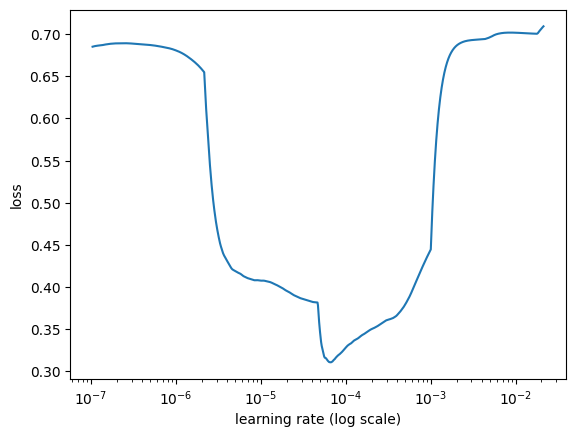

In [ ]:
learner.lr_plot()

Now, use the tuned learner to train the best model.

Here, we define a limit of 10 epochs, but in reality, this should stop much sooner due to early stopping.  As it turns out early stopping, was implemented after the 2nd epoch in autofitting the learner. Our likely best model fit accuraccy was probably given in the first epoch of the model autofit where the second epoch of autofitting since improvement in validation had a slight decline.  It is worth remembering early stopping prevents overfitting which is made more clear in the second epoch training accuracy versus validation accuracy compared to the first epoch (i.e., growth in difference between values).

In [ ]:
history=learner.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
753/753 [==============================] - 184s 230ms/step - loss: 0.3862 - accuracy: 0.8333 - val_loss: 0.3000 - val_accuracy: 0.8692
Epoch 2/10
753/753 [==============================] - 165s 220ms/step - loss: 0.2376 - accuracy: 0.9088 - val_loss: 0.3078 - val_accuracy: 0.8670
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
Weights from best epoch have been loaded into model.


Get the predictor

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

Optionally, uncomment this code to save the predictor and reload it later. Note, the saved models can be quite large and may quickly use up space on your Google Drive.

In [ ]:
#predictor.save("drive/MyDrive/MSDSTextClassification_Lab2.healthy_living")


##  **DistilBERT Model Confusion Matrix Summary**


We can see below the negative class (i.e., articles not related to Healthy Living) have a precision of around 94%. This represents the true positives of articles not related to Healthy Living relative to the combined total of articles that are false positives (i.e., those that are technically Healthy Living but misclassified as Not Healthy Living). The precision score for this class is among the highest of all precision and recall scores. When the model predicts Not Healthy, it is correct 94% of the time (precision). That is, there are very few false positives. For the negative class, the model finds 80% of the true Not Healthy articles, and it misses 20% of them (recall).

The positive class (i.e., articles related to Healthy Living) scored the highest in recall. The model finds 95% of the true Healthy articles, and it misses 5% of them (recall). On the other hand, when the model predicts healthy, it is correct 81% of the time (precision).

Overall, the model is aggressive at finding Healthy Living articles, but it consequently accepts a higher false positive rate for this class, meaning the model is willing to accept more misclassifications of articles as Healthy Living. It is worth noting accordingly that the model is better served as a filter for capturing Healthy Living articles (high recall) than for reliably filtering Not Healthy Living articles.

Overall, the F1 Score is generally good in the range of production-grade transformer classifiers at 87%. This is better than Bag of Words, logistic regression baselines, and small CNN/GRU text models. This is also marginally improved compared to Vargo's benchmarks.





In [ ]:
validation = learner.validate(val_data=val, print_report=True)

42/42 [==============================] - 7s 118ms/step
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       693
           1       0.81      0.95      0.87       645

    accuracy                           0.87      1338
   macro avg       0.88      0.87      0.87      1338
weighted avg       0.88      0.87      0.87      1338



In [ ]:
!pip show ktrain transformers tokenizers

Name: ktrain
Version: 0.41.4
Summary: ktrain is a wrapper for TensorFlow Keras that makes deep learning and AI more accessible and easier to apply
Home-page: https://github.com/amaiya/ktrain
Author: Arun S. Maiya
Author-email: arun@maiya.net
License: Apache License 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: chardet, charset-normalizer, fastprogress, jieba, joblib, keras-bert, langdetect, matplotlib, packaging, pandas, requests, scikit-learn, sentencepiece, syntok, tika, transformers, whoosh
Required-by: 
---
Name: transformers
Version: 4.57.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, huggingf

###  **Roberta Model** ###

The main differences between BERT and RoBERTa center on tokenization and pretraining strategy. BERT uses a WordPiece tokenizer, while RoBERTa (and DistilRoBERTa) use Byte-Pair Encoding (BPE), which generally provides stronger multilingual robustness and better handling of rare or novel terms. However, for our “Healthy Living” classification task, this advantage could be marginal because the domain does not critically depend on multilingual coverage or unusual vocabulary.

In pretraining, BERT optimizes both Masked Language Modeling (MLM) and Next Sentence Prediction (NSP). RoBERTa removes NSP and relies solely on dynamic MLM, which re-masks inputs on each pass to encourage richer contextual learning. RoBERTa also benefits from training on more data, using larger batches, and training for longer overall. These refinements generally make RoBERTa more robust and higher performing. That said, for a relatively straightforward classification task like ours, the performance improvements over BERT may be modest if the task does not demand the added robustness RoBERTa provides.

Our implmentation takes a slightly different route since there aren't any defined "roberta-base" or "distilroberta" preprocessors for `ktrain.text.texts_from_df()`  In this case, we have to manually `train_test_split()` and call the `ktrain.text` transformer, and finally we have to preprocess train and validation separately to get our preprocessed train and validation sets which are applied to the learner.  Otherwise, there is a similar handling approach with respect to optimizing the learner via tuning, and then using autofit on the learner with the parameter tuned settings.

In [ ]:
from sklearn.model_selection import train_test_split
from ktrain import text

MODEL_NAME = "roberta-base"   # or "distilroberta-base"
MAXLEN = 128
classes = ["not_healthy", "healthy"]

# 1) stratified split from your cleaned dataframe
train_df, val_df = train_test_split(
    review_sample[["combined_text_clean","healthy"]],
    test_size=0.1,
    random_state=42,
    stratify=review_sample["healthy"]
)

# 2) build Transformer preprocessor
t = text.Transformer(
    model_name=MODEL_NAME,
    maxlen=MAXLEN,
    class_names=classes
)

# 3) preprocess train and validation separately
trn = t.preprocess_train(
    train_df["combined_text_clean"].tolist(),
    train_df["healthy"].tolist()
)
val = t.preprocess_test(
    val_df["combined_text_clean"].tolist(),
    val_df["healthy"].tolist()
)

# 4) get classifier
model = t.get_classifier()

preprocessing train...
language: en
train sequence lengths:
	mean : 29
	95percentile : 58
	99percentile : 70


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 28
	95percentile : 58
	99percentile : 69


/usr/local/lib/python3.12/dist-packages/ktrain/text/preprocessor.py:1093: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(


In [ ]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=16)


In [ ]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
752/752 [==============================] - 334s 418ms/step - loss: 0.6017 - accuracy: 0.6477
Epoch 2/6
752/752 [==============================] - 317s 422ms/step - loss: 0.3565 - accuracy: 0.8513
Epoch 3/6
752/752 [==============================] - 317s 421ms/step - loss: 0.5664 - accuracy: 0.6511
Epoch 4/6
752/752 [==============================] - 316s 420ms/step - loss: 1.1998 - accuracy: 0.5012
Epoch 5/6
752/752 [==============================] - 5s 6ms/step - loss: 2.9231 - accuracy: 0.5588


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


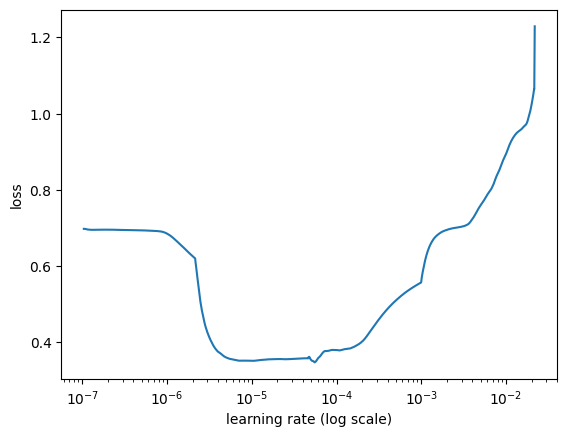

In [ ]:
learner.lr_plot()

In [ ]:
history=learner.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
753/753 [==============================] - 362s 455ms/step - loss: 0.5028 - accuracy: 0.7748 - val_loss: 0.4843 - val_accuracy: 0.7773
Epoch 2/10
753/753 [==============================] - 329s 436ms/step - loss: 0.4716 - accuracy: 0.8016 - val_loss: 0.5528 - val_accuracy: 0.7795
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
Weights from best epoch have been loaded into model.


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

### **RoBERTa Model – Confusion Matrix Summary**

The negative class (Not Healthy) shows strong precision at 94%, meaning that when the model predicts an article is not related to Healthy Living, it is correct 94% of the time. This reflects a low false-positive rate. However, recall for this class is lower at 59%, indicating that the model only identifies about 59% of all true Not Healthy articles, missing roughly 41% of them.

The positive class (Healthy) shows the opposite pattern. Recall is very high at 96%, meaning the model successfully captures nearly all healthy-living articles. Precision for this class is 70%, meaning that when the model predicts an article is healthy, it is correct 70% of the time. This indicates a higher false-positive rate for the healthy class, consistent with its aggressive identification behavior.

Overall accuracy is 78%, with macro and weighted F1 scores of 0.77, reflecting reduced balance relative to DistilBERT. Compared with the DistilBERT results, RoBERTa appears more aggressive in identifying Healthy Living content (higher recall) but at the cost of more misclassification of Not Healthy material (lower recall in the negative class). In short, the model prioritizes capturing Healthy Living articles over correctly filtering out unrelated content, resulting in an asymmetrical performance profile: excellent recall on healthy content but reduced recall for not_healthy content.


In [ ]:
validation = learner.validate(val_data=val, print_report=True)

42/42 [==============================] - 17s 267ms/step
              precision    recall  f1-score   support

           0       0.94      0.59      0.73       669
           1       0.70      0.96      0.81       669

    accuracy                           0.78      1338
   macro avg       0.82      0.78      0.77      1338
weighted avg       0.82      0.78      0.77      1338



###  **DistilRoberta Model** ###

Given the results from the RoBERTa base model, we might hope for some improved model performance.  However, it is worth keep in mind, that rarely do distillation models exceed teacher models, so could we be looking at similar results in the DistilRoBERTa case?   We use a templated and nearly duplicate approach for the DistilRoBERTa Model as with the RoBERTa Model.  Again, we automate learner tuning, and then autofit the learner with parameter optimization.

In [ ]:
from sklearn.model_selection import train_test_split
from ktrain import text

MODEL_NAME = "distilroberta-base"   # or "distilroberta-base"
MAXLEN = 128
classes = ["not_healthy", "healthy"]

# 1) stratified split from your cleaned dataframe
train_df, val_df = train_test_split(
    review_sample[["combined_text_clean","healthy"]],
    test_size=0.1,
    random_state=42,
    stratify=review_sample["healthy"]
)

# 2) build Transformer preprocessor
t = text.Transformer(
    model_name=MODEL_NAME,
    maxlen=MAXLEN,
    class_names=classes
)

# 3) preprocess train and validation separately
trn = t.preprocess_train(
    train_df["combined_text_clean"].tolist(),
    train_df["healthy"].tolist()
)
val = t.preprocess_test(
    val_df["combined_text_clean"].tolist(),
    val_df["healthy"].tolist()
)

# 4) get classifier
model = t.get_classifier()

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/331M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 29
	95percentile : 58
	99percentile : 70


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 28
	95percentile : 58
	99percentile : 69


/usr/local/lib/python3.12/dist-packages/ktrain/text/preprocessor.py:1093: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(


In [ ]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=16)


In [ ]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
752/752 [==============================] - 178s 222ms/step - loss: 0.5801 - accuracy: 0.6844
Epoch 2/6
752/752 [==============================] - 169s 225ms/step - loss: 0.3582 - accuracy: 0.8509
Epoch 3/6
752/752 [==============================] - 169s 225ms/step - loss: 0.5230 - accuracy: 0.7075
Epoch 4/6
752/752 [==============================] - 168s 224ms/step - loss: 1.0847 - accuracy: 0.4995
Epoch 5/6
752/752 [==============================] - 5s 7ms/step - loss: 2.1260 - accuracy: 0.5400


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


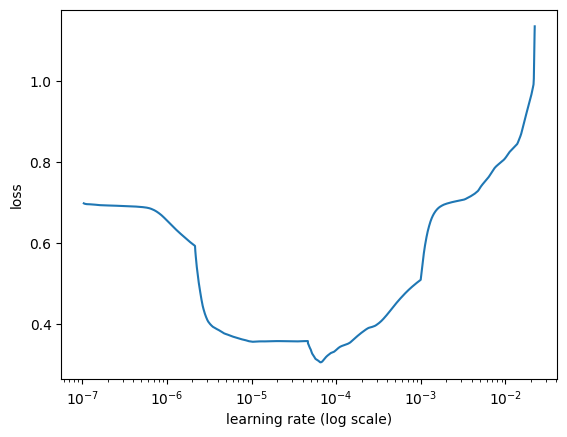

In [ ]:
learner.lr_plot()

In [ ]:
history=learner.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
753/753 [==============================] - 202s 250ms/step - loss: 0.4338 - accuracy: 0.8124 - val_loss: 0.3439 - val_accuracy: 0.8550
Epoch 2/10
753/753 [==============================] - 179s 238ms/step - loss: 0.3060 - accuracy: 0.8787 - val_loss: 0.3400 - val_accuracy: 0.8543
Epoch 3/10
753/753 [==============================] - 176s 233ms/step - loss: 0.2475 - accuracy: 0.9027 - val_loss: 0.3561 - val_accuracy: 0.8520
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 2.
Weights from best epoch have been loaded into model.


## **DistilRoBERTa Model Performance** ###

Compared to DistilBERT, it appears we have comparable model performance with DistilRoBERTa.  Training and validation accuracy appear to have peaked in 2nd Epoch autofitting at around 85% which is within a +/- 1% validation accuracy for DistilBERT results.

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)



##  **DistilRoBERTa Model -Confusion Matrix Summary**



We can see below the negative class (i.e., articles not related to Healthy Living) has a precision of around 88%. This represents the true positives of articles not related to Healthy Living relative to the combined total of articles that are false positives (i.e., those that are technically Healthy Living but misclassified as Not Healthy Living). The precision score is among the highest of all precision and recall scores. When the model predicts Not Healthy, it is correct 88% of the time (precision). That is, there are still few false positives. For the negative class, the model finds 82% of the true Not Healthy articles, and it misses 18% of them (recall).

The positive class (i.e., articles related to Healthy Living) scored the highest in recall. The model finds 89% of the true Healthy articles, and it misses 11% of them (recall). On the other hand, when the model predicts Healthy, it is correct 83% of the time (precision).

Overall, the model is slightly less aggressive at finding Healthy Living articles compared to the DistilBERT model, with a slight F1 score decline of 2% (85% overall accuracy). However, it also accepts a slightly lower false positive rate compared to DistilBERT. Accordingly, the model is slightly better served for balanced capturing of Healthy Living articles compared to Not Healthy Living as a filter.





In [ ]:
validation = learner.validate(val_data=val, print_report=True)

42/42 [==============================] - 7s 139ms/step
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       669
           1       0.83      0.89      0.86       669

    accuracy                           0.85      1338
   macro avg       0.86      0.85      0.85      1338
weighted avg       0.86      0.85      0.85      1338




#  **Confusion-Matrix Results Summary Overall**

| **Model**         | **Class**            | **Precision** | **Recall** | **F1-Score** | **Support** |
| ----------------- | -------------------- | ------------- | ---------- | ------------ | ----------- |
| **DistilBERT**    | 0 (not_healthy)      | 0.94          | 0.80       | 0.86         | 693         |
|                   | 1 (healthy)          | 0.81          | 0.95       | 0.87         | 645         |
|                   | **Overall Accuracy** | **0.87**      | —          | —            | 1338        |
|                   | **Macro Avg**        | 0.88          | 0.87       | 0.87         | —           |
|                   | **Weighted Avg**     | 0.88          | 0.87       | 0.87         | —           |
|                   |                      |               |            |              |             |
| **DistilRoBERTa** | 0 (not_healthy)      | 0.88          | 0.82       | 0.85         | 669         |
|                   | 1 (healthy)          | 0.83          | 0.89       | 0.86         | 669         |
|                   | **Overall Accuracy** | **0.85**      | —          | —            | 1338        |
|                   | **Macro Avg**        | 0.86          | 0.85       | 0.85         | —           |
|                   | **Weighted Avg**     | 0.86          | 0.85       | 0.85         | —           |
|                   |                      |               |            |              |             |
| **RoBERTa**       | 0 (not_healthy)      | 0.94          | 0.59       | 0.73         | 669         |
|                   | 1 (healthy)          | 0.70          | 0.96       | 0.81         | 669         |
|                   | **Overall Accuracy** | **0.78**      | —          | —            | 1338        |
|                   | **Macro Avg**        | 0.82          | 0.78       | 0.77         | —           |
|                   | **Weighted Avg**     | 0.82          | 0.78       | 0.77         | —           |

---



###  Summary of Results  ###


Across the three models evaluated—DistilBERT, DistilRoBERTa, and RoBERTa—the strongest overall balance of performance and efficiency came from DistilRoBERTa. DistilBERT, the smallest and fastest model in the group, offered solid accuracy and well-balanced precision and recall, making it a strong baseline for lightweight deployment. Its primary limitation is slightly weaker semantic representation, as WordPiece tokenization and a simpler pretraining objective give it less depth than RoBERTa-based alternatives.

DistilRoBERTa improved on DistilBERT by leveraging RoBERTa’s more robust pretraining (dynamic MLM, no NSP) and BPE tokenization, which yields stronger contextual understanding and better handling of rare terms. It maintained relatively compact size while offering more balanced and consistent class performance, making it the most favorable option for this task given its strong F1 scores and efficient resource use.

Full RoBERTa provided the richest language modeling capacity but at a higher computational cost and with less balanced behavior. Although it achieved excellent recall for Healthy Living articles, it did so by over-predicting positives, leading to weaker recall on not-healthy content and lower overall accuracy. This suggests that the added representational power does not translate into meaningfully better performance for this classification task.

From a contextual advertising perspective, these differences are notable: DistilRoBERTa provides the best foundation for scalable targeting workflows, balancing accuracy with operational efficiency while limiting false positives that may degrade ad relevance. DistilBERT provides a lightweight alternative where latency or cost constraints dominate, while RoBERTa’s higher recall could be justified only in domains where capturing as many relevant topics as possible outweighs precision—potentially at the cost of wasted impressions and less efficient campaign spend.

In summary, DistilBERT is fast and reliable; DistilRoBERTa offers the best trade-off between accuracy and efficiency for contextual advertising needs; and RoBERTa provides the strongest language representation but weaker balance and higher cost, making it less suitable unless maximum recall for Healthy Living content is the overriding priority.



# Inspecting the drivers of prediction

No matter what the supervised machine learning model, you always want to peak under the hood to see what features are driving prediction. That is, what words sway the outcome of the prediction. It's harder to inspect a neural network. Because all of the layers of a neural network aren't really interpretable to the human eye.

Currently, the best practice I've found is a little tool Explainable AI:
https://alvinntnu.github.io/python-notes/nlp/ktrain-tutorial-explaining-predictions.html

In [ ]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

Let's go ahead and make a little set of test documents to check out

In [ ]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.'
             ]

In [ ]:
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy is %s' % probs[1])
  print(text)

*These* are pretty obvious examples, but it works exactly as expected!

In [ ]:
predictor.explain('Diversity is the key to a healthy society. Here is what we need to do to make america a more equitable place to live for all.')

But you can see, this algorithm is far from perfect. Here you can see that it's probably got too high of an emphasis on the word "healthy."

So what would I do next? Well, given that it's over reacting to worrds like health and equitable, I'd try introducing more negative examples into the data, times where healthy is used outside of health and wellness news. We can do this by changing our sample from 50/50 to something like 20/80, but of course, the more documents we process, the longer this model is going to take to make!